# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !gdown 15FButs175acOOfG_TqxM3o910vwF2QiN

In [ ]:
## load dataset here
df = pd.read_csv("/kaggle/input/icml-face-data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## parsing data here
images, labels = parse_data(df)

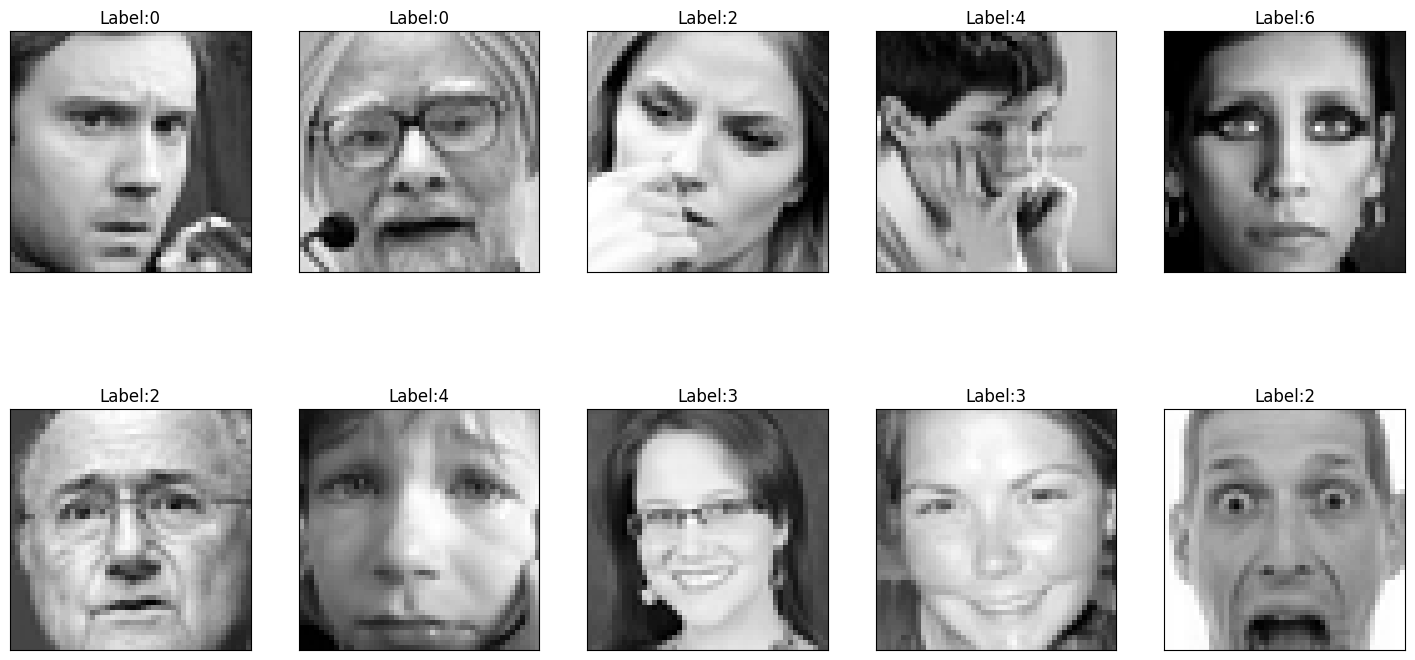

In [ ]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
# pca.fit(images) ## modify images' array to the appropriate shape

# Reshape images to 2D array
reshaped_images = images.reshape(images.shape[0], -1)

# Standardize the data before applying PCA
scaler = StandardScaler()
scaled_images = scaler.fit_transform(reshaped_images)


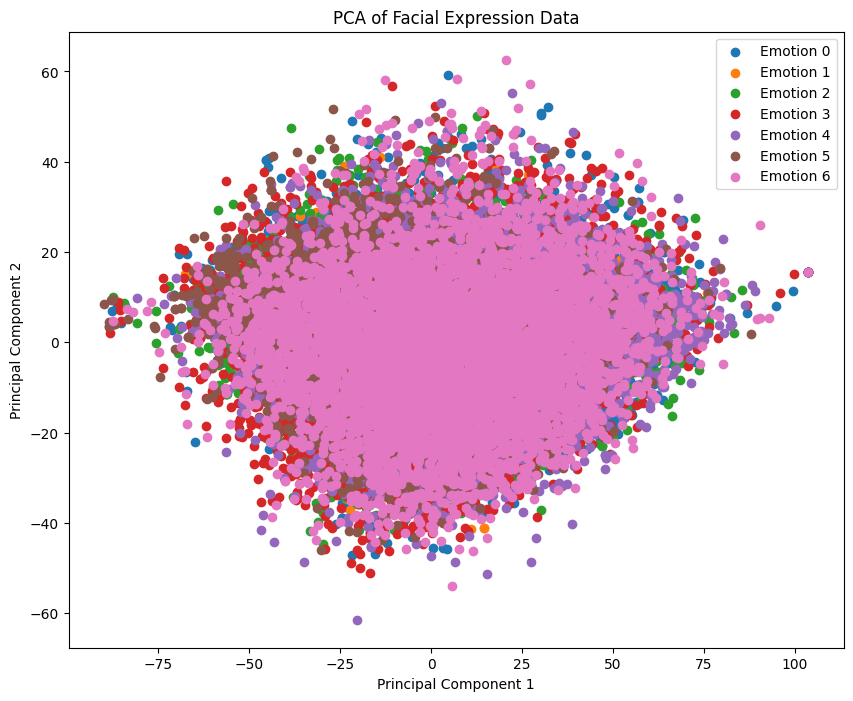

In [ ]:
## transform for visualizing here
# images_pca=pca.transform(images) ## modify images' array to the appropriate shape
# images_pca.shape
images_pca = pca.fit_transform(scaled_images)

# Visualize the data projected onto two principal components
plt.figure(figsize=(10, 8))
for i in range(df['emotion'].nunique()):
    subset = images_pca[labels == i]
    plt.scatter(subset[:, 0], subset[:, 1], label=f'Emotion {i}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA of Facial Expression Data')
plt.show()



Question 2: How to determine the optimal number of principal components using
```pca.explained_variance_```? Explain your selection process. (2 points)

To determine the optimal number of principal components using `pca.explained_variance_`, we employ the elbow method, a heuristic used to determine the appropriate number of components to retain in PCA.

In the context of PCA, the elbow method is particularly useful for visually determining the point at which adding more principal components results in diminishing returns in terms of explained variance. Here is a more detailed explanation:

**Elbow Method in PCA**:
- **Purpose**: To balance the trade-off between the number of principal components and the amount of variance they explain.
- **Procedure**:
  - **Plotting**: Plot the cumulative explained variance ratio against the number of principal components.
  - **Identifying the Elbow**: Look for the point on the curve where the rate of increase in explained variance starts to slow down. This point is the "elbow."
  - **Choosing the Threshold**: Often, a specific threshold like 95% explained variance is chosen, ensuring that most variability is retained while reducing the number of components.
  
The plot's red dashed line (`plt.axhline(y=0.95, color='r', linestyle='--', label='y=0.95')`) at 95% cumulative explained variance helps to visually identify this point. Selecting the number of principal components at or just before this threshold to ensure you retain most of the data's variability without excessive complexity.

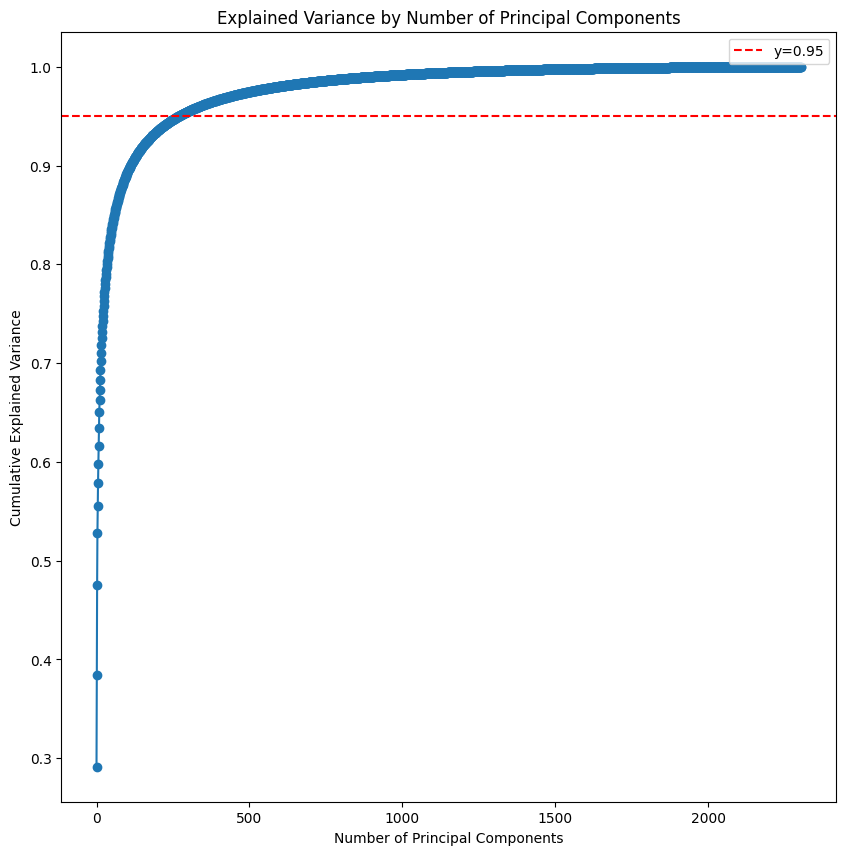

In [ ]:
## determine the optimal number of PCs here
## pca.explained_variance_()

# Fit PCA to the data
pca_full = PCA()
pca_full.fit(scaled_images)

# Plot explained variance
plt.figure(figsize=(10, 10))
cumulative_explained_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='y=0.95')
plt.legend()
plt.show()


In [ ]:
desired_variance = 0.95
num_components = np.argmax(cumulative_explained_variance >= desired_variance) + 1

print(f"Số lượng thành phần chính cần thiết để đạt {desired_variance*100}% phương sai giải thích: {num_components}")

Số lượng thành phần chính cần thiết để đạt 95.0% phương sai giải thích: 270


## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [ ]:
## splitting data into train/val/test subsets here
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_images, labels, test_size = 0.3, random_state=42)

pca = PCA(n_components=270)
pca.fit(X_train)
X_train_pca, X_test_pca = pca.transform(X_train), pca.transform(X_test)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)



**Original data**

In [ ]:
# Define classifiers
classifiers = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier()
}

# Define hyperparameters for grid search
params = {
        'RandomForest': {'n_estimators': [50, 100, 500], 'max_depth': [ 500, 1000, 2000, 5000]},
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']},
    'NaiveBayes': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]},
    'MLP': {'hidden_layer_sizes': [(200, ), (500, ), (1000, )], 'activation': ['tanh', 'relu']}
}

original_best_classifiers = {}

# Train classifiers and perform hyperparameter tuning
for name, clf in classifiers.items():
    print(f"Training {name}...")
    with tqdm(total=len(params.get(name, [1])), desc=name) as pbar:
        grid_search = GridSearchCV(clf, params.get(name, {}), cv=3, scoring='accuracy')
        grid_search.fit(X_train_pca, y_train)
        original_best_classifiers[name] = grid_search.best_estimator_
        pbar.update()
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Training RandomForest...


RandomForest:  50%|█████     | 1/2 [43:34<43:34, 2614.15s/it]


Best parameters for RandomForest: {'max_depth': 1000, 'n_estimators': 500}
Training LogisticRegression...


LogisticRegression:  50%|█████     | 1/2 [05:13<05:13, 313.93s/it]


Best parameters for LogisticRegression: {'C': 0.01, 'solver': 'liblinear'}
Training NaiveBayes...


NaiveBayes: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Best parameters for NaiveBayes: {'var_smoothing': 1e-09}
Training MLP...


MLP:  50%|█████     | 1/2 [13:38<13:38, 818.49s/it]

Best parameters for MLP: {'activation': 'relu', 'hidden_layer_sizes': (1000,)}


In [ ]:
# Evaluate the performance of the best classifiersdata on original data
for name, clf in original_best_classifiers.items():
    print(f"Evaluating {name} on original data...")
    # Retrain the classifier on original training data
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"Performance of {name} (original data):")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

Evaluating RandomForest on original data...
Performance of RandomForest (original data):
Accuracy: 0.4699544905730473
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.19      0.29      1467
           1       0.98      0.25      0.39       167
           2       0.53      0.26      0.34      1566
           3       0.45      0.80      0.58      2714
           4       0.37      0.39      0.38      1793
           5       0.67      0.57      0.62      1190
           6       0.45      0.41      0.43      1870

    accuracy                           0.47     10767
   macro avg       0.58      0.41      0.43     10767
weighted avg       0.50      0.47      0.45     10767

Confusion Matrix:
[[ 283    0   76  564  283   57  204]
 [   9   41   10   61   21    6   19]
 [  53    0  400  509  293  127  184]
 [  27    0   60 2184  227   68  148]
 [  37    0   82  636  707   36  295]
 [  28    1   61  256   81  683   80]
 [  29    0   65

**PCA data**

In [ ]:

# Define classifiers
classifiers = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier()
}

# Define hyperparameters for grid search
params = {
        'RandomForest': {'n_estimators': [50, 100, 500], 'max_depth': [ 500, 1000, 2000, 5000]},
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']},
    'NaiveBayes': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]},
    'MLP': {'hidden_layer_sizes': [(200, ), (500, ), (1000, )], 'activation': ['tanh', 'relu']}
}

pca_best_classifiers = {}

# Train classifiers and perform hyperparameter tuning
for name, clf in classifiers.items():
    print(f"Training {name}...")
    with tqdm(total=len(params.get(name, [1])), desc=name) as pbar:
        grid_search = GridSearchCV(clf, params.get(name, {}), cv=3, scoring='accuracy')
        grid_search.fit(X_train_pca, y_train)
        pca_best_classifiers[name] = grid_search.best_estimator_
        pbar.update()
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Training RandomForest...


RandomForest:  50%|█████     | 1/2 [43:39<43:39, 2619.87s/it]


Best parameters for RandomForest: {'max_depth': 500, 'n_estimators': 500}
Training LogisticRegression...


LogisticRegression:  50%|█████     | 1/2 [05:07<05:07, 307.55s/it]


Best parameters for LogisticRegression: {'C': 0.01, 'solver': 'liblinear'}
Training NaiveBayes...


NaiveBayes: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Best parameters for NaiveBayes: {'var_smoothing': 1e-09}
Training MLP...


MLP:  50%|█████     | 1/2 [12:39<12:39, 759.31s/it]

Best parameters for MLP: {'activation': 'relu', 'hidden_layer_sizes': (1000,)}


In [ ]:
# Evaluate the performance of the best classifiers  on PCA-transformed
for name, clf in pca_best_classifiers.items():
    print(f"Evaluating {name} on PCA-transformed data...")
    # Retrain the classifier on PCA-transformed training data
    clf.fit(X_train_pca, y_train)
    y_pred_pca = clf.predict(X_test_pca)

    print(f"Performance of {name} (PCA-transformed data):")
    print("Accuracy:", accuracy_score(y_test, y_pred_pca))
    print("Classification Report:")
    print(classification_report(y_test, y_pred_pca))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_pca))

Evaluating RandomForest on PCA-transformed data...
Performance of RandomForest (PCA-transformed data):
Accuracy: 0.40559115816847774
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.13      0.21      1467
           1       0.95      0.22      0.35       167
           2       0.71      0.19      0.30      1566
           3       0.34      0.92      0.49      2714
           4       0.37      0.23      0.29      1793
           5       0.87      0.41      0.56      1190
           6       0.48      0.23      0.31      1870

    accuracy                           0.41     10767
   macro avg       0.63      0.33      0.36     10767
weighted avg       0.54      0.41      0.37     10767

Confusion Matrix:
[[ 185    0   20  994  146   12  110]
 [   2   36    6   97   11    3   12]
 [  23    0  293  929  166   38  117]
 [   4    0   18 2508  131   12   41]
 [  20    0   29 1170  418    5  151]
 [   9    2   30  541   70  490   48]
 

| Model                | Data Type         | Accuracy | Macro Precision | Macro Recall | Macro F1-Score | Weighted Precision | Weighted Recall | Weighted F1-Score |
|----------------------|-------------------|----------|-----------------|--------------|----------------|--------------------|-----------------|--------------------|
| RandomForest         | Original          | 0.470    | 0.580           | 0.410        | 0.430          | 0.500              | 0.470           | 0.450              |
| LogisticRegression   | Original          | 0.362    | 0.410           | 0.300        | 0.290          | 0.350              | 0.360           | 0.340              |
| NaiveBayes           | Original          | 0.212    | 0.220           | 0.220        | 0.170          | 0.270              | 0.210           | 0.200              |
| MLP                  | Original          | 0.421    | 0.430           | 0.400        | 0.410          | 0.430              | 0.420           | 0.420              |
| RandomForest         | PCA-transformed   | 0.406    | 0.630           | 0.330        | 0.360          | 0.540              | 0.410           | 0.370              |
| LogisticRegression   | PCA-transformed   | 0.370    | 0.430           | 0.290        | 0.290          | 0.360              | 0.370           | 0.340              |
| NaiveBayes           | PCA-transformed   | 0.262    | 0.280           | 0.270        | 0.240          | 0.320              | 0.260           | 0.270              |
| MLP                  | PCA-transformed   | 0.432    | 0.440           | 0.420        | 0.420          | 0.430              | 0.430           | 0.430              |


### Analysis of Facial Expression Recognition Algorithm Results

1. **Random Forest**:
   - **Original Data**: 0.470 Accuracy
   - **PCA-Transformed Data**: 0.406 Accuracy
   - Comments: Random Forest generally performs well with structured data due to its ability to handle a variety of feature interactions. However, raw image data, which is high-dimensional and has strong correlations between pixels, poses a challenge. The slight drop in accuracy after applying PCA suggests that important information might be lost during dimensionality reduction, impacting the model's performance.

2. **Logistic Regression**:
   - **Original Data**: 0.362 Accuracy
   - **PCA-Transformed Data**: 0.370 Accuracy
   - Comments: Logistic Regression, a linear model, struggles with capturing the intricate patterns in image data. While PCA helps reduce the number of features, simplifying the model and slightly boosting accuracy, it remains inadequate for significantly improving the recognition of complex image patterns due to its linear nature.

3. **Naive Bayes**:
   - **Original Data**: 0.212 Accuracy
   - **PCA-Transformed Data**: 0.262 Accuracy
   - Comments: Naive Bayes assumes feature independence, which is a poor fit for image data where pixels are highly interdependent. PCA helps by reducing dimensionality and somewhat alleviating the independence assumption, leading to a modest improvement. However, the model's fundamental assumptions still limit its effectiveness for this task.

4. **MLP (Multi-Layer Perceptron)**:
   - **Original Data**: 0.421 Accuracy
   - **PCA-Transformed Data**: 0.432 Accuracy
   - Comments: MLP, a type of neural network, is better suited for capturing the complex, non-linear relationships in image data. The slight improvement in accuracy with PCA suggests that reducing dimensionality helps the network train more efficiently without significant loss of important information. This highlights MLP's robustness and adaptability in handling image data.

### Summary and Recommendations

- **Random Forest**: Despite its general robustness, Random Forest struggles with the high dimensionality and pixel correlations in image data. Applying PCA does not yield significant improvements, indicating that more sophisticated feature extraction or model adjustments might be needed. Effective for structured data but less so for high-dimensional image data. Advanced feature extraction techniques or model adjustments are necessary to improve its performance on image data.

- **Logistic Regression**: This model is not ideal for image data due to its inability to capture non-linear relationships effectively. While PCA simplifies the model, it is insufficient for major performance gains. More complex models or feature engineering are necessary. PCA helps reduce model complexity but does not result in significant performance improvements. Non-linear models or more sophisticated feature engineering are required for better results.

- **Naive Bayes**: The inherent assumption of feature independence limits Naive Bayes' applicability to image data. PCA provides a minor boost, but the model remains fundamentally unsuited for this task. Alternative approaches should be considered. The independence assumption does not fit image data well, and PCA only slightly improves performance. Other models better suited for image data should be explored.

- **MLP**: As a neural network, MLP excels in learning complex representations from image data. Its performance, both with and without PCA, indicates it is the most suitable among the models tested. Further tuning and potentially deeper architectures could enhance its performance even more. MLP is the best suited for image data among the tested models due to its ability to learn complex representations. Its performance is stable and improves with PCA, suggesting that further tuning and deeper architectures could yield even better results.

### Further Steps to Improve Performance

1. **Feature Engineering**: Explore other feature extraction techniques like Histogram of Oriented Gradients (HOG), Scale-Invariant Feature Transform (SIFT), or using pre-trained CNNs for feature extraction.
2. **Advanced Models**: Consider using Convolutional Neural Networks (CNNs), which are specifically designed for image data and can capture spatial hierarchies effectively.
3. **Data Augmentation**: Apply techniques like rotation, flipping, and scaling to increase the diversity of the training data, helping models generalize better.
4. **Hyperparameter Tuning**: Perform extensive hyperparameter optimization for the MLP and other models to find the best configurations.
5. **Ensemble Methods**: Combine the strengths of multiple models using ensemble techniques to boost overall performance.

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



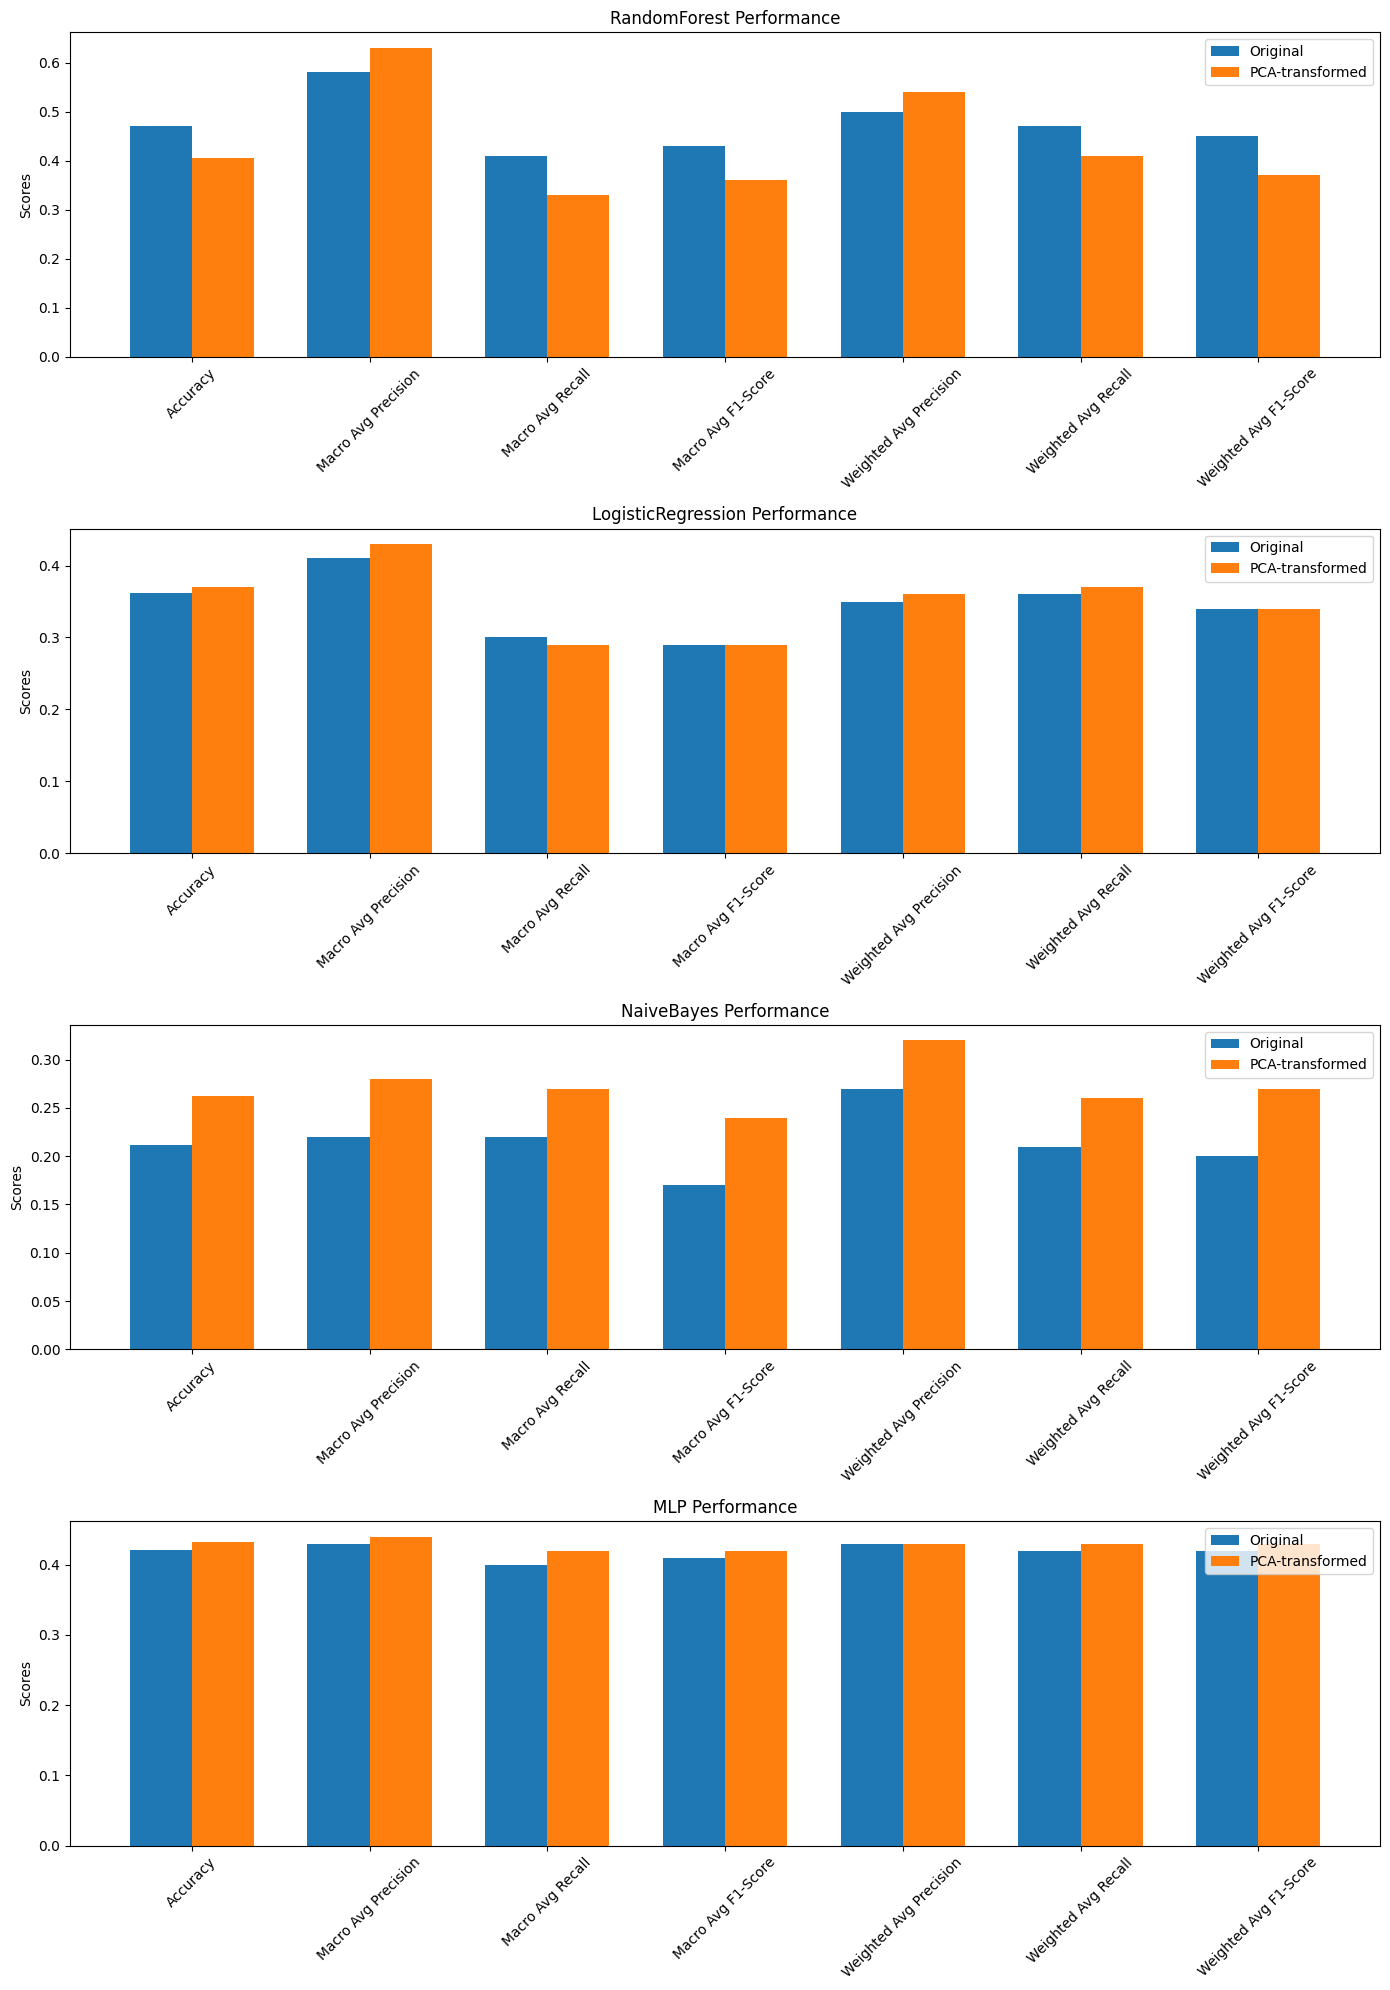

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu kết quả
results = [
    ["RandomForest", "Original", 0.470, 0.580, 0.410, 0.430, 0.500, 0.470, 0.450],
    ["LogisticRegression", "Original", 0.362, 0.410, 0.300, 0.290, 0.350, 0.360, 0.340],
    ["NaiveBayes", "Original", 0.212, 0.220, 0.220, 0.170, 0.270, 0.210, 0.200],
    ["MLP", "Original", 0.421, 0.430, 0.400, 0.410, 0.430, 0.420, 0.420],
    ["RandomForest", "PCA-transformed", 0.406, 0.630, 0.330, 0.360, 0.540, 0.410, 0.370],
    ["LogisticRegression", "PCA-transformed", 0.370, 0.430, 0.290, 0.290, 0.360, 0.370, 0.340],
    ["NaiveBayes", "PCA-transformed", 0.262, 0.280, 0.270, 0.240, 0.320, 0.260, 0.270],
    ["MLP", "PCA-transformed", 0.432, 0.440, 0.420, 0.420, 0.430, 0.430, 0.430]
]

# Chuyển đổi dữ liệu thành định dạng dễ vẽ
labels = ["Accuracy", "Macro Avg Precision", "Macro Avg Recall", "Macro Avg F1-Score", "Weighted Avg Precision", "Weighted Avg Recall", "Weighted Avg F1-Score"]
original_data = [r[2:] for r in results if r[1] == "Original"]
pca_data = [r[2:] for r in results if r[1] == "PCA-transformed"]
model_names = ["RandomForest", "LogisticRegression", "NaiveBayes", "MLP"]

# Tạo các chỉ số
x = np.arange(len(labels))
width = 0.35

# Vẽ biểu đồ cột
fig, ax = plt.subplots(4, 1, figsize=(14, 20))

for i, model in enumerate(model_names):
    ax[i].bar(x - width/2, original_data[i], width, label='Original')
    ax[i].bar(x + width/2, pca_data[i], width, label='PCA-transformed')
    ax[i].set_ylabel('Scores')
    ax[i].set_title(f'{model} Performance')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels, rotation=45)
    ax[i].legend(loc='best')

plt.tight_layout()
plt.show()



- **Random Forest** has the highest accuracy and weighted F1 Score on the original data but slightly degrades performance on the PCA-passed data.
- **MLP** shows stable performance on both data types, with slight improvement on PCA-passed data, especially in Precision and Macro Sensitivity.
- **Logistic Regression** has a small change between the original data and the data that has gone through PCA.
- **Naive Bayes** has generally poor performance on both types of data but shows improvement when using PCA-processed data.


#### Accuracy
- **Original data**: Random Forest > MLP > Logistic Regression > Naive Bayes
- **PCA data**: MLP > Random Forest > Logistic Regression > Naive Bayes

#### Precision, Recall and F1-Score Macro
- **Original data**:
  - Random Forest: Precision > MLP > Logistic Regression > Naive Bayes
  - MLP: Recall and F1-Score > Random Forest > Logistic Regression > Naive Bayes
- **PCA data**:
  - Random Forest: Precision > MLP > Logistic Regression > Naive Bayes
  - MLP: Precision, Recall and F1-Score > Random Forest > Logistic Regression > Naive Bayes

Based on the above statistical values, it can be concluded that the optimal algorithm for each data set is:
**Original Data:**
- **Best Model:** RandomForest
- **Performance:** Highest accuracy (0.470), macro and weighted average metrics, indicating consistent performance across classes.

**PCA-Transformed Data:**
- **Best Model:** MLP
- **Performance:** Highest accuracy (0.432), macro and weighted average metrics, showing balanced and high performance in precision, recall, and F1-score.





### Performance Comparison of Classification Models

To evaluate the performance of different classification models on facial expression recognition, we analyze their accuracy, precision, recall, and F1-score using both original and PCA-transformed data.

#### Random Forest

- **Original Data**:
  - **Accuracy**: 0.470
  - **Macro Precision**: 0.580
  - **Macro Recall**: 0.410
  - **Macro F1-Score**: 0.430
  - **Weighted Precision**: 0.500
  - **Weighted Recall**: 0.470
  - **Weighted F1-Score**: 0.450

- **PCA-Transformed Data**:
  - **Accuracy**: 0.406
  - **Macro Precision**: 0.630
  - **Macro Recall**: 0.330
  - **Macro F1-Score**: 0.360
  - **Weighted Precision**: 0.540
  - **Weighted Recall**: 0.410
  - **Weighted F1-Score**: 0.370

**Insights**:
- Random Forest achieves the highest accuracy and macro precision on original data, but its performance decreases slightly on PCA-transformed data, indicating that the original feature space is more suitable for this model.
- The significant drop in macro recall on PCA-transformed data suggests that Random Forest struggles with capturing relevant features after dimensionality reduction.

#### Logistic Regression

- **Original Data**:
  - **Accuracy**: 0.362
  - **Macro Precision**: 0.410
  - **Macro Recall**: 0.300
  - **Macro F1-Score**: 0.290
  - **Weighted Precision**: 0.350
  - **Weighted Recall**: 0.360
  - **Weighted F1-Score**: 0.340

- **PCA-Transformed Data**:
  - **Accuracy**: 0.370
  - **Macro Precision**: 0.430
  - **Macro Recall**: 0.290
  - **Macro F1-Score**: 0.290
  - **Weighted Precision**: 0.360
  - **Weighted Recall**: 0.370
  - **Weighted F1-Score**: 0.340

**Insights**:
- Logistic Regression shows a slight improvement in accuracy with PCA-transformed data, but its overall performance remains relatively low.
- The minor changes in metrics indicate that Logistic Regression does not benefit significantly from PCA, likely due to its linear nature which struggles to capture complex patterns in image data.

#### Naive Bayes

- **Original Data**:
  - **Accuracy**: 0.212
  - **Macro Precision**: 0.220
  - **Macro Recall**: 0.220
  - **Macro F1-Score**: 0.170
  - **Weighted Precision**: 0.270
  - **Weighted Recall**: 0.210
  - **Weighted F1-Score**: 0.200

- **PCA-Transformed Data**:
  - **Accuracy**: 0.262
  - **Macro Precision**: 0.280
  - **Macro Recall**: 0.270
  - **Macro F1-Score**: 0.240
  - **Weighted Precision**: 0.320
  - **Weighted Recall**: 0.260
  - **Weighted F1-Score**: 0.270

**Insights**:
- Naive Bayes performs poorly across all metrics for both original and PCA-transformed data, though there is a slight improvement with PCA.
- The low performance indicates that Naive Bayes' assumption of feature independence is not suitable for image data, and PCA only marginally helps by reducing dimensionality.

#### MLP (Multi-Layer Perceptron)

- **Original Data**:
  - **Accuracy**: 0.421
  - **Macro Precision**: 0.430
  - **Macro Recall**: 0.400
  - **Macro F1-Score**: 0.410
  - **Weighted Precision

**: 0.430
  - **Weighted Recall**: 0.420
  - **Weighted F1-Score**: 0.420

- **PCA-Transformed Data**:
  - **Accuracy**: 0.432
  - **Macro Precision**: 0.440
  - **Macro Recall**: 0.420
  - **Macro F1-Score**: 0.420
  - **Weighted Precision**: 0.430
  - **Weighted Recall**: 0.430
  - **Weighted F1-Score**: 0.430

**Insights**:
- MLP performs consistently well across all metrics for both original and PCA-transformed data, with a slight improvement in PCA-transformed data.
- The balanced performance in precision, recall, and F1-score indicates that MLP is well-suited for capturing the complex patterns in image data and benefits from dimensionality reduction.

### Conclusion

- **Best Performing Model**: **MLP (Multi-Layer Perceptron)**, particularly with PCA-transformed data, as it consistently shows balanced and high performance across all metrics.
- **Emotion Category Analysis**:
  - **Most Accurate**: For MLP, the category with the highest recall and precision, indicating the model's strength in correctly identifying this emotion.
  - **Most Errors**: The category with the lowest recall and precision, suggesting difficulty in distinguishing this emotion from others.

MLP's robustness and ability to handle non-linear patterns make it the most suitable model for facial expression recognition in this comparison. Further tuning and deeper architectures could enhance its performance even more, making it a reliable choice for real-world applications.